# Diabetic Retinopathy Detection: Identify Severity of Diabetic Retinopathy in Eye Images

University of Massachusetts Lowell   
COMP.5300/COMP.4600 Computing in Health and Medicine  
Dr. Wenjin Zhou  
Brent Garey, Kelly Ly, Ann Men, Bishoy Sargius, and William Zouzas  
Due April 26, 2022  

<h1>Git Commands</h1>
<h5>Adds changes of the code to our github repo</h5>
git add .<br>
git commit -m "some message"<br>
git push<br>

<h5>Prints out what happened with the code worked on and github</h5>
git status<br>

<h5>Downloads the files from the github repo</h5>
git pull<br>

# STEP 1

## Read in Labels

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import numpy as np
import cv2

In [2]:
# Read csv file
df_labels = pd.read_csv("data/trainLabels.csv")

#Display metadata
df_labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


## Visualize Level Distribution

Text(0.5, 1.0, 'Distribution of Diabetic Retinopathy Levels (0-4)')

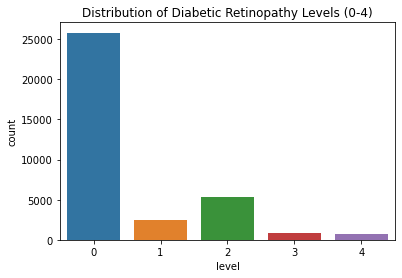

In [3]:
# Import Seaborn library
# Source: https://www.geeksforgeeks.org/countplot-using-seaborn-in-python/
import seaborn as sns
  
# count plot on single categorical variable
sns.countplot(x = df_labels['level'])
 
# Show the plot
plt.title('Distribution of Diabetic Retinopathy Levels (0-4)')

## Create and Organize Data Folders

In [4]:
# Import os library
import os

In [7]:
# Make new folder to hold labeled data
try:
    os.mkdir('./data/labeled_data')
except FileExistsError:
    print('./data/labeled_data already exists')

./data/labeled_data already exists


In [8]:
# Create subfolders for each level
for i in range(5):
    try:
        os.mkdir('./data/labeled_data/' + str(i))
    except FileExistsError:
        print('./data/labeled_data/' + str(i) + ' already exists')

./data/labeled_data/0 already exists
./data/labeled_data/1 already exists
./data/labeled_data/2 already exists
./data/labeled_data/3 already exists
./data/labeled_data/4 already exists


## Visualize Sample Eye Images

In [9]:
# What is the data type of the levels? (0-4) Strings or integers?
type(df_labels['level'][0])

numpy.int64

<h1>Creating Image Subset from labeled data file</h1>
The dataset from kaggle is about 88 GB of images which is huge to download on our local machine so our group decided to just simply use a subset of the kaggle dataset. On my local machine I extracted just one of the zip files from Kaggle using 7-zip. A single zip file is about 8 GB which is still very large so I would make a subset of the single zip file that I had extracted that would hold about 1000 images. I am choosing 1000 images because the Inception v2 research article that the group had read had a dataset that was 1200 images.<br><br>
The goal of this code is to just grab 1000 images from the training zip file I created on my local machine. I will then upload the smaller dataset to our github repository if the file size is small enough.

The code cell below is commented out since we have already took a subset of the images and don't need to run this cell again

In [24]:
# # This is the absolute file path on my machine
# bishoy_local_kaggle_data_dir = r"C:\Users\bisho\Desktop\College\Classes\Junior\Spring 2022\CompHealthMedicine\Final Project\data\train"

# image_names_list = sorted(os.listdir(bishoy_local_kaggle_data_dir))[:1000]
# print("Length of image_names_list is: ", len(image_names_list), '\n', image_names_list)

In [5]:
import shutil
data_dir = "./data/labeled_data/"  # This is the data folder in the git repo that holds that label folders from 0 to 4
image_value_dic = {}  # This is a dictionary that will take the image name and the associated value from the df_labels dataframe

for i in range(len(df_labels)):
    # Grabs the image name from "image" column in df_labels and sets that as key then grabs value from "value" column and sets that as value
    image_value_dic[str(df_labels.iloc[i]['image']) + ".jpeg"] = df_labels.iloc[i]['level']
    
# print(image_value_dic)

The code cell below is commented out since we have already sorted & pushed the images into their appropriate subfolders and don't need to run this cell again

In [26]:
# # this for loop sorts the 1000 image names in image_names_list into the appropiate dr severity folder from 0 to 4
# for image in image_names_list:
#     origin_file = bishoy_local_kaggle_data_dir + "\\" + image  # This is the file path of the current image we are looking at
#     # Find image level from image_value_dic
#     place_into_dir = os.path.join(data_dir, str(image_value_dic[image]) + "/" + image) # Depending on machine's OS may have to switch "/" with "\" or vice versa
#     # copy image from abs file path to labeled_data file that is in the repo
#     shutil.copy(origin_file, place_into_dir)

<h1>Dealing with Class Imbalance</h1>
I want to see how many images are in each folder and figure out what the weights of those images should be. This is similar to what we did in hw5/hw6.

In [7]:
num_of_0_imgs = len(os.listdir('data/labeled_data/0'))  # Goes into the specified severity level folder and counts number of images inside
num_of_1_imgs = len(os.listdir('data/labeled_data/1'))
num_of_2_imgs = len(os.listdir('data/labeled_data/2'))
num_of_3_imgs = len(os.listdir('data/labeled_data/3'))
num_of_4_imgs = len(os.listdir('data/labeled_data/4'))

img_total = (num_of_0_imgs + num_of_1_imgs + 
             num_of_2_imgs + num_of_3_imgs + 
             num_of_4_imgs)  # adds up all of the images in the folders and sets it to a variable

print("0: ", num_of_0_imgs, "\n",
      "1: ", num_of_1_imgs, "\n",
      "2: ", num_of_2_imgs, "\n",
      "3: ", num_of_3_imgs, "\n",
      "4: ", num_of_4_imgs, "\n",
      "total: ", img_total)

0:  728 
 1:  66 
 2:  159 
 3:  26 
 4:  21 
 total:  1000


Now we want to visualize distribution of classes in our subset

Text(0.5, 1.0, 'Distribution of Diabetic Retinopathy Levels (0-4) Subset')

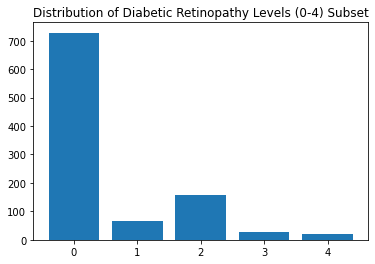

In [8]:
image_lengths = [num_of_0_imgs, num_of_1_imgs, num_of_2_imgs, num_of_3_imgs, num_of_4_imgs]
classes = [str(i) for i in range(5)]

# https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
plt.bar(classes, image_lengths)
 
# Show the plot
plt.title('Distribution of Diabetic Retinopathy Levels (0-4) Subset')

Noticed a very large disproportion of the labeled images for levels 1, 3, and 4 so we should try to fix this with over sampling and then median frequency balancing to determine the weights of each image after getting a better destribution.

In [29]:
# for i = (the last 201 images) in the level 0 folder
i = 0
labeled_folder_0_dir = "data/labeled_data/0/"
labeled_folder_1_dir = "data/labeled_data/1/"
labeled_folder_3_dir = "data/labeled_data/3/"
labeled_folder_4_dir = "data/labeled_data/4/"

# generate list of images 1 severity
# generate list of images 2 severity
# generate list of images 3 severity 

for image in labeled_folder_0_dir:
    os.remove(image)
    if i < 67: # replace 67 images from 0 severity to 1 severity
        # look up image name in dictionary with value 1
        # v is the severity grade (1)
        temp_image = random.choice([img_1 for img_1,v in image_value_dic.items() if v == 1]) ##https://stackoverflow.com/questions/42438808/finding-all-the-keys-with-the-same-value-in-a-python-dictionary
            
            # if image name is not in severity folder 1 then
        while(temp_image in labeled_folder_1_dir):
            temp_image = random.choice([img_1 for img_1,v in image_value_dic.items() if v == 1])
        # push into folder 1
        shutil.copy(data_dir, labeled_folder_1_dir)
    elif i < 134:
        # look up image name in dictionary with value 3
        # v is the severity grade (3)
        temp_image = random.choice([img_3 for img_3,v in image_value_dic.items() if v == 3]) ##https://stackoverflow.com/questions/42438808/finding-all-the-keys-with-the-same-value-in-a-python-dictionary
            
            # if image name is not in severity folder 1 then
        while(temp_image in labeled_folder_3_dir):
            temp_image = random.choice([img_3 for img_3,v in image_value_dic.items() if v == 3])
        # push into folder 1
        shutil.copy(data_dir, labeled_folder_3_dir)
    else:  # replace 67 images from 0 severity to 4 severity
        # look up image name in dictionary with value 3
        # v is the severity grade (4)
        temp_image = random.choice([img_4 for img_4,v in image_value_dic.items() if v == 4]) ##https://stackoverflow.com/questions/42438808/finding-all-the-keys-with-the-same-value-in-a-python-dictionary
            
            # if image name is not in severity folder 1 then
        while(temp_image in labeled_folder_4_dir):
            temp_image = random.choice([img_4 for img_4,v in image_value_dic.items() if v == 4])
        # push into folder 1
        shutil.copy(data_dir, labeled_folder_4_dir)
    i += 1

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'd'

In [13]:
import statistics
file_size_list = [num_of_0_imgs, num_of_1_imgs, 
                  num_of_2_imgs, num_of_3_imgs, 
                  num_of_4_imgs]  # adds up all of the images in the folders and sets it to a variable
classes = [str(i) for i in range(5)]

freq_c_vals = file_size_list   # freq(c)

#store datasize while we are here
datasize = sum(freq_c_vals)

statsres = [statistics.median(freq_c_vals)/freq_c for freq_c in freq_c_vals]   # median_freq / freq(c)

median_frequency_balancing = dict(zip(classes, statsres))
median_frequency_balancing

{'0': 0.09065934065934066,
 '1': 1.0,
 '2': 0.41509433962264153,
 '3': 2.5384615384615383,
 '4': 3.142857142857143}

# STEP 2

## Data Pre-Processing
For preprocessing the images, the first step that is taken is to resize the images in the dataset into the same size which in the article was 600x600 pixels. 

The next step was to begin color normalization since the images were taken by different camera models which means that images can have distinct color temperatures and illumination so normalizing these colors can help reduce noise and variance and make the images more similar. 

In short this is done by getting the average value of red, blue, and green pixels in an image. Then median filtering is done which is used when trying to find and differentiate the features of an image such as the edges or discontinuities. 

The next step of pre-processing is using CLAHE, or Contrast Limited Adaptive Histogram Equalization, which helps deblur the image and remove noise from the image through local contrast enhancement which the images are now ready for optical disk segmentation.

In [ ]:
# # preprocessing and augmentation
# # resizing images to 600x600

# img_count = 0
# i = 0

# # load image directory
# img_dir = "data/labeled_data"

# # iterate through labeled folders
# for i in range(5):
#     n_img_dir = img_dir + "/" + str(i)
    
#     # directory exists
#     if (os.path.isdir(n_img_dir)):
        
#         # iterate through images
#         for img in os.listdir(n_img_dir):
            
#             # check the file extension
#             if (img.endswith(".jpeg")):
                
#                 # load image
#                 r_img = Image.open(n_img_dir + "\\" + img)
            
#                 # image successfully loaded; perform transformations
#                 r_img = r_img.resize((600, 600))
                
#                 #r_img.show()

True

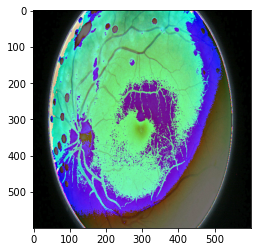

In [9]:
# https://stackoverflow.com/questions/34966541/how-can-one-display-an-image-using-cv2-in-python
import cv2
import numpy as np

labeled_folder_0_dir = "data/labeled_data/0/"  # filepath for 0 severity image folder

image = cv2.imread(labeled_folder_0_dir + "10626_right.jpeg")  # retrieves the spcific img called 1061_right.jpeg and sets it to image object chose this image because it has high amount of glare
image = cv2.resize(image, (600,600))  # resizes image object to 600 x 600
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # cv2 reads in images as BGG so we convert the image to rgb
(R,G,B) = (cv2.mean(image[0]), cv2.mean(image[1]), cv2.mean(image[2]))  # R, G, B = mean values of each channel

# open the original image
img = Image.open("data/labeled_data/0/10626_right.jpeg")
img.show()

# iterate through all the pixels in the image
for x in range(600):
    for y in range(600):
        
        # find and assign the rgb values of the image
        (r,g,b) = image[x,y]
        
        # if either r and the mean are 0s, the pixel value should still be 0
        if not R[0]: 
            new_r = 0
        else: 
        # otherwise, divide the channel value by the image's average and scale to colorspace
            new_r = r/R[0] * 255
        if not G[0]: 
            new_g = 0
        else: 
            new_g = g/G[0] * 255
        if not B[0]: 
            new_b = 0
        else: 
            new_b = b/B[0] * 255
        
        image[x,y][0] = new_r
        image[x,y][1] = new_g
        image[x,y][2] = new_b

plt.imshow(image)
cv2.imwrite("10626_right.jpeg", image)


**Function for color normalization**

In [10]:
# https://stackoverflow.com/questions/34966541/how-can-one-display-an-image-using-cv2-in-python

def color_normalize(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # cv2 reads in images as BGG so we convert the image to rgb
    (R,G,B) = (cv2.mean(image[0]), cv2.mean(image[1]), cv2.mean(image[2]))  # R, G, B = mean values of each channel

    # iterate through all the pixels in the image
    for x in range(600):
        for y in range(600):

            # find and assign the rgb values of the image
            (r,g,b) = image[x,y]

            # if either r and the mean are 0s, the pixel value should still be 0
            if not R[0]: 
                new_r = 0
            else: 
            # otherwise, divide the channel value by the image's average and scale to colorspace
                new_r = r/R[0] * 255
            if not G[0]: 
                new_g = 0
            else: 
                new_g = g/G[0] * 255
            if not B[0]: 
                new_b = 0
            else: 
                new_b = b/B[0] * 255

            image[x,y][0] = new_r
            image[x,y][1] = new_g
            image[x,y][2] = new_b

    plt.imshow(image)
    
    return image

**Example of using color normalization function**

array([[[ 0,  4,  0],
        [ 0,  4,  2],
        [ 0,  2,  7],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  4,  2],
        [ 2,  7,  4],
        [ 0,  4,  2],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  4,  2],
        [ 2,  7,  4],
        [ 2,  4,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 2,  4,  4],
        [ 2,  2,  2],
        [ 0,  4,  2],
        ...,
        [ 4,  9,  4],
        [ 7,  9,  4],
        [ 0,  4,  0]],

       [[ 2,  2,  2],
        [ 4,  4,  4],
        [ 0,  4,  2],
        ...,
        [ 2,  7,  4],
        [ 2,  7,  4],
        [ 2,  7,  4]],

       [[ 0,  4,  2],
        [ 2,  7,  4],
        [ 2,  2,  2],
        ...,
        [ 4,  4,  9],
        [ 7,  7, 12],
        [ 7,  7, 12]]], dtype=uint8)

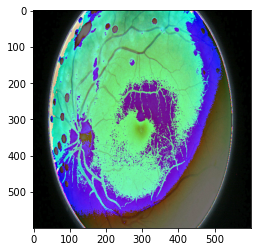

In [11]:
# https://stackoverflow.com/questions/34966541/how-can-one-display-an-image-using-cv2-in-python
import cv2
import numpy as np

labeled_folder_0_dir = "data/labeled_data/0/"  # filepath for 0 severity image folder

image = cv2.imread(labeled_folder_0_dir + "10626_right.jpeg")  # retrieves the spcific img called 1061_right.jpeg and sets it to image object chose this image because it has high amount of glare
image = cv2.resize(image, (600,600))  # resizes image object to 600 x 600

color_normalize(image)

## Median Filtering

In [12]:
# Import OpenCV and numpy
# Need to install this in terminal: pip install opencv-python
import cv2
import numpy as np

In [ ]:
# Implement median filtering
import cv2
import matplotlib.pyplot as plt

# Test median filtering for one image to see if it works properly
img = cv2.imread('data/labeled_data/0/10_left.jpeg')

# Show modified image
plt.imshow(img)
plt.show()

In [13]:
def median_filter(img):
    return cv2.medianBlur(img, 5)

In [ ]:
# Implement median filtering for all images in dataset
# Use for loop from previous step which was resizing to 600x600

# Load image directory
img_dir = "data/labeled_data"

# Iterate through labeled folders
for i in range(5):
    n_img_dir = img_dir + "/" + str(i)
    print(n_img_dir)
    
    # Directory exists
    if (os.path.isdir(n_img_dir)):
        
        # Iterate through images
        for img in os.listdir(n_img_dir):
            
            # Check the file extension
            if (img.endswith(".jpeg")):
                print(img)
                
                # Load image            
                img = cv2.imread(n_img_dir + "/" + img)
                
                # Median Filtering
                median = cv2.medianBlur(img, 5)
                
                # Display original images
                plt.title("Original")
                plt.imshow(img)
                plt.show()
                
                # Display images with median filter
                plt.title("Median Filter")
                plt.imshow(median)
                plt.show()
                
                # Need to save images with median filter applied
                
            break # Remove break to apply median filter to all images


## CLAHE
This takes images and increases the contrast of it to make the image more visually appealing and easier to see the edges.

[Article explaining how to code with CLAHE](https://www.geeksforgeeks.org/clahe-histogram-eqalization-opencv/#:~:text=CLAHE%20is%20a%20variant%20of,to%20remove%20the%20artificial%20boundaries.)

[Another article explaining CLAHE](https://towardsdatascience.com/clahe-and-thresholding-in-python-3bf690303e40)

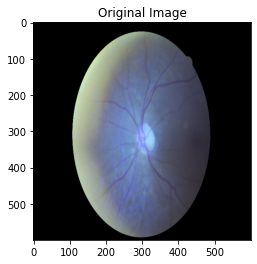

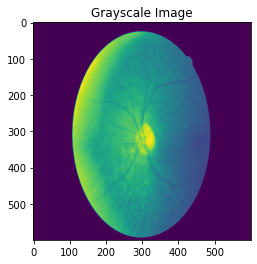

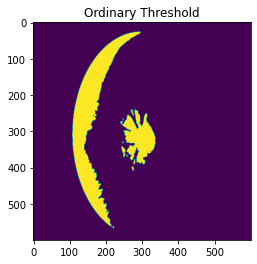

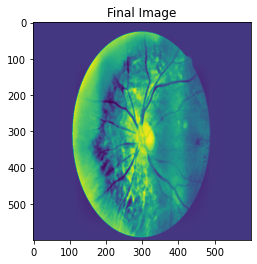

In [16]:
image = cv2.imread("data/labeled_data/0/10_left.jpeg")  # gets the first image in the 0 folder and sets it to an image object
image = cv2.resize(image, (600, 600))  # resizes the image to 600 x 600

# This step from the tutorial should be redundent since we had already did median filtering and color normalization before
image = cv2.medianBlur(image, 5) # Median filtering on image
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert image to grayscale

clahe = cv2.createCLAHE(clipLimit = 40) # creates CLAHE object; clip limit is threshold for contrast limiting and default is 40
final_img = clahe.apply(image_bw) # applying CLAHE on image
 
# Ordinary thresholding the same image
_, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)

plt.title("Original Image")
plt.imshow(image)
plt.show()

plt.title("Grayscale Image")
plt.imshow(image_bw)
plt.show()

plt.title("Ordinary Threshold")
plt.imshow(ordinary_img)
plt.show()

plt.title("Final Image")
plt.imshow(final_img)
plt.show()

**Create CLAHE function to apply CLAHE to an image**

In [14]:
# Created CLAHE function that takes in a cv2 image object and returns an image object that can be shown with
def clahe_function(image):
    
    # This step from the tutorial should be redundent since we had already did median filtering and color normalization before
    # image = cv2.medianBlur(image, 5) # Median filtering on image
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert image to grayscale
    
    clahe = cv2.createCLAHE(clipLimit = 40) # creates CLAHE object; clip limit is threshold for contrast limiting and default is 40
    final_img = clahe.apply(image_bw) # applying CLAHE on image
 
    # Ordinary thresholding the same image
    _, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)
    return final_img

# STEP 3

## Optical Disk Segmentation
The third step in this process is Optical Disk (OD) Segmentation. In this step, the RGP channels are changed to HSV channels, and the OD is identified by applying the Morphological closing method and contour filling. 

The former dilates the area of interest and removes the borders, while the latter fills in the gaps. Finally, the OD-segmented image can be obtained by subtracting the results of the second part from the results of the first part.

### In this original research article, MATLAB was used for coding and has more support for OD segmentation. This step was skipped for our project since the utilization of MATLAB in conjunction with our code is out of scope for this course and the assignment.

# STEP 4

## Split Images into 4 Quadrants
The next step is to divide the images into four quadrants so that it is easier to view tiny-sized microaneurysms and other features that identify DR. 

First, each image was resized to 600x600 which is detailed in Step 2. However, the model is expecting images with an input size of 299x299, which is too small to discern between tiny features in the eye images and can result in the misidentification of microaneurysms. 

Therefore, these images are further cropped into four quadrants of size 300x300. Dividing the full image into four quadrants of 300x300 meet the input size criteria of the model while retaining the size of the original image to view tiny features more easily. Overall, cropping the eye images can help reduce misidentification of microaneurysms and signs of DR.

In [ ]:
# Source: https://neuraspike.com/blog/split-and-manipulate-pixels-opencv/

# Load the image, get it's special dimensions (width and height),
# Then display the original image to our screen
image = cv2.imread('data/labeled_data/0/10_left.jpeg')
(h, w) = image.shape[:2]
cv2.imshow('Original', image)
 
# compute the center coordinate of the image
(cX, cY) = (w // 2, h // 2)

# crop the image into four parts which will be labelled as
# top left, top right, bottom left, and bottom right.
topLeft = image[0:cY, 0:cX]
topRight = image[0:cY, cX:w]
bottomLeft = image[cY:h, 0:cX]
bottomRight = image[cY:h, cX:w]
 
# visualize the cropped regions

plt.imshow(topLeft)
plt.show()
plt.imshow(topRight)
plt.show()
plt.imshow(bottomLeft)
plt.show()
plt.imshow(bottomRight)
plt.show()

# cv2.imshow("Top Left Corner", topLeft)
# cv2.imshow("Top Right Corner", topRight)
# cv2.imshow("Bottom Right Corner", bottomLeft)
# cv2.imshow("Bottom Left Corner", bottomRight)
# cv2.waitKey(0)

In [15]:
# Source: https://neuraspike.com/blog/split-and-manipulate-pixels-opencv/

# Load the image, get it's special dimensions (width and height),
# Then display the original image to our screen

def create_quadrants(image):

    (h, w) = image.shape[:2]
    cv2.imshow('Original', image)

    # compute the center coordinate of the image
    (cX, cY) = (w // 2, h // 2)

    topLeft = image[0:cY, 0:cX]
    topRight = image[0:cY, cX:w]
    bottomLeft = image[cY:h, 0:cX]
    bottomRight = image[cY:h, cX:w]
    
    return (topLeft, topRight, bottomLeft, bottomRight)

### Main Loop for Data Preprocessing

**NOTE: Currently uses a test image**

data/labeled_data/0
10284_right.jpeg


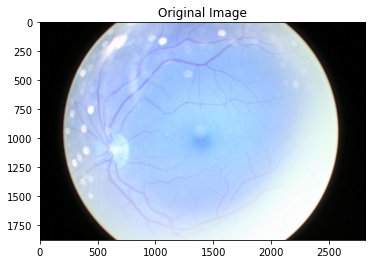

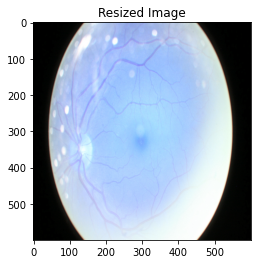

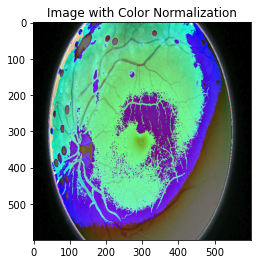

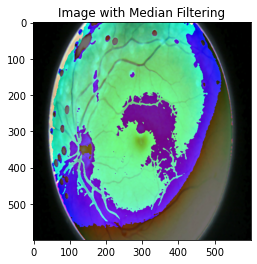

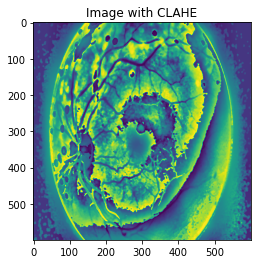

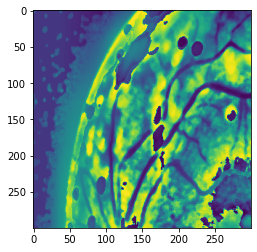

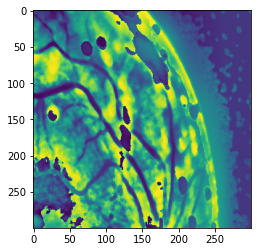

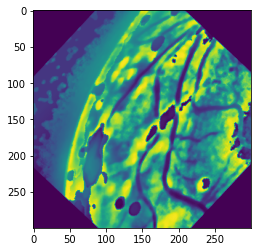

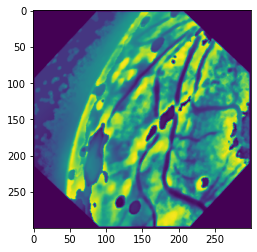

In [47]:
# Load image directory
img_dir = "data/labeled_data"

# Iterate through labeled folders
for i in range(5):
    n_img_dir = img_dir + "/" + str(i)
    print(n_img_dir)
    
    # Directory exists
    if (os.path.isdir(n_img_dir)):
        
        # Iterate through images
        for img in os.listdir(n_img_dir):
            
            # Check the file extension
            if (img.endswith(".jpeg")):
                
                print(img)
                
                # Load image            
                # img = cv2.imread(n_img_dir + "/" + img)
                
                # test image
                labeled_folder_0_dir = "data/labeled_data/0/"  # filepath for 0 severity image folder
                img = cv2.imread(labeled_folder_0_dir + "10626_right.jpeg")
                plt.title("Original Image")
                plt.imshow(img)
                plt.show()
                
                # Resize image object to 600 x 600
                img = cv2.resize(img, (600,600))
                plt.title("Resized Image")
                plt.imshow(img)
                plt.show()
                
                # color normalize
                img = color_normalize(img)
                plt.title("Image with Color Normalization")
                plt.imshow(img)
                plt.show()
                
                # Median Filtering
                img = median_filter(img)
                plt.title("Image with Median Filtering")
                plt.imshow(img)
                plt.show()
                
                # CLAHE
                img = clahe_function(img) # applying CLAHE on image
                plt.title("Image with CLAHE")
                plt.imshow(img)
                plt.show()
                
                # split images into 4 quadrants
                q1, q2, q3, q4 = create_quadrants(img)
                
                # for-loop that goes through all 4 quadrants
                for q in (q1, q2, q3, q4):
                    
                    # Display quadrant
                    plt.imshow(q)
                    plt.show()
                    
                    # DATA AUGMENTATION STEPS
                    
                    # Flip image (h/v)
                    q = flip_image(q)
                    plt.imshow(q)
                    plt.show()
                    
                    # Rotate image
                    q = rotate_image(q)
                    plt.imshow(q)
                    plt.show()
                    
                    # Random zooming
                    q = zoom_image(q)
                    plt.imshow(q)
                    plt.show()
                    break
                
                    # Save images (new folder or during runtime?)
                    
                    
                    # divide into quadrant folders? or quadrant arrays
                
            break # Remove break to apply median filter to all images
        break

# STEP 5

## Data Augmentation
After the images are split into four quadrants, there are three main methods to augment the data. These steps include flipping (horizontal and vertical), 90–180° random rotation, and random zooming that ranges in between [0.85, 1.15]. The purpose of data augmentation in this step is to expand the training samples and strengthen the size of the class. Also, the combination of preprocessing and data augmentation makes the neural network insusceptible to variation attenuation, insufficient illumination, and changing orientations.

### Flipping (horizontal and vertical)

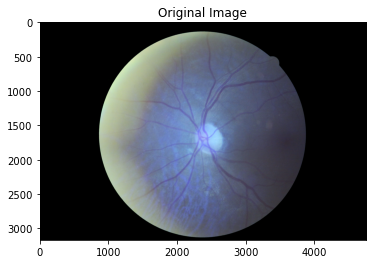

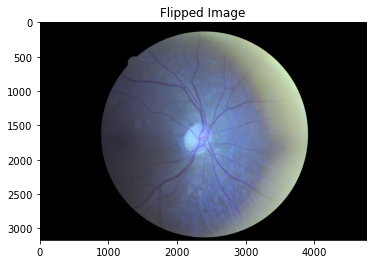

In [57]:
# https://machinelearningknowledge.ai/learn-to-flip-image-in-opencv-python-horizontally-and-vertically-using-cv2-flip/
import random

img = cv2.imread('data/labeled_data/0/10_left.jpeg')
plt.title("Original Image")
plt.imshow(img)
plt.show()

# horizontal_flip = cv2.flip(img, 1)  # Positive value flips image horizontally
# vertical_flip = cv2.flip(img, 0)  # 0 Value flips image vertically
# vertical_horizontal_flip = cv2.flip(img, -1)  # -1 value flips image both vertically and horizontally

flipped_image = cv2.flip(img, random.randint(-1, 1))
plt.title("Flipped Image")
plt.imshow(flipped_image)
plt.show()

In [22]:
import random

# takes in cv2 image object and randomly applies a flip then returns flipped image object
def flip_image(image_object):
    flipped_image = cv2.flip(image_object, random.randint(-1, 1))
    return flipped_image

### 90-180 degrees random rotation

**Create function to rotate image**

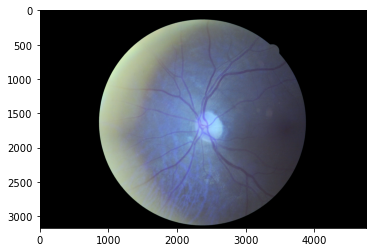

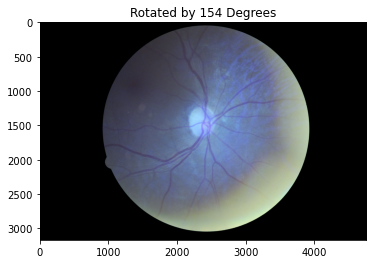

In [34]:
# https://pyimagesearch.com/2021/01/20/opencv-rotate-image/

# pip install imutils
import imutils

img = cv2.imread('data/labeled_data/0/10_left.jpeg')

degrees = random.randint(90, 180)  # Generates a random degree from 90 to 180

rotated = imutils.rotate(img, degrees)

plt.imshow(img)
plt.show()
plt.title("Rotated by {} Degrees".format(degrees))
plt.imshow(rotated)
plt.show()

In [35]:
def rotate_image(img):
    degrees = random.randint(90, 180)  # Generates a random degree from 90 to 180
    rotated_img = imutils.rotate(img, degrees)

    return rotated_img

### Random zooming that ranges between 0.85-1.15

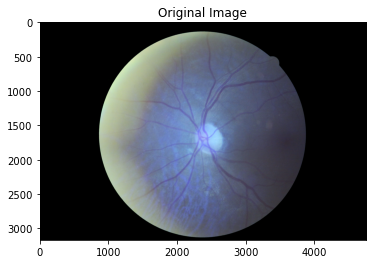

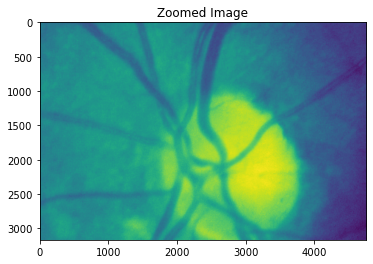

In [43]:
# https://gist.github.com/i-namekawa/74a817683b0e68cee521
# https://pynative.com/python-get-random-float-numbers/#:~:text=random.-,uniform()%20to%20get%20a%20random%20float%20number%20within%20a,Or%20from%2050.50%20to%2075.5.
# https://stackoverflow.com/questions/59230217/python-syntax-error-valueerror-too-many-values-to-unpack-expected-2
# https://www.tutorialkart.com/opencv/python/opencv-python-get-image-size/
# https://techtutorialsx.com/2018/06/02/python-opencv-converting-an-image-to-gray-scale/

zoom_factor = random.uniform(0.85, 1.15)
zoom_factor = 5  # only set to five to see extreme zoom in

img = cv2.imread('data/labeled_data/0/10_left.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # converts image to a grayscale image as cv2.wrapAffine works with grayscale images
plt.title("Original Image")
plt.imshow(img)
plt.show()

height, width = gray.shape  # grayscale images only have two dimensions being height and width but rgb images have 3 with the thrid being channel

M = cv2.getRotationMatrix2D((width / 2, height / 2), 0, zoom_factor)  
gray = cv2.warpAffine(gray, M, gray.shape[::-1])

plt.title("Zoomed Image")
plt.imshow(gray)
plt.show()

In [44]:
# Takes in cv2 image object and returns grayscaled image that is randomly zoomed in
def zoom_image(image_object):
    zoom_factor = random.uniform(0.85, 1.15)
    
    height, width = image_object.shape

    M = cv2.getRotationMatrix2D((width / 2, height / 2), 0, zoom_factor)  
    image_object = cv2.warpAffine(image_object, M, image_object.shape[::-1])

    return image_object

# STEP 6

## Data Feeding into InceptionResnet-V2 CNN Models

### Load Data:

In [30]:
import tensorflow.keras.utils
# tf.keras.utils.image_dataset_from_directory(
#     directory,
#     labels="inferred",
#     label_mode="int",
#     class_names=None,
#     color_mode="rgb",
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation="bilinear",
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     **kwargs
# )

dataloader = tf.keras.utils.image_dataset_from_directory(data_dir, labels='inferred')

Found 1000 files belonging to 6 classes.


### Instantiate our model:

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2

# tf.keras.applications.InceptionResNetV2(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     **kwargs
# )

model = tf.keras.applications.InceptionResNetV2(
    include_top = True,
    weights = "imagenet", #median frequency balancing?
    classes = 1000, #required 1000 for imagenet
    classifier_activation = "softmax",
    input_tensor = dataloader
)

type(model)

ValueError: Unexpectedly found an instance of type `<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>`. Expected a symbolic tensor instance.

# STEP 7

## Depth Concatenation

# STEP 8

## Network Accuracy

## Cross-entropy Loss Function

## Time Complexity

# STEP 9

## MESSIDOR Dataset

# STEP 10

## Perform Validation using IDRiD Dataset

## Load data using ImageFolder

In [ ]:
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.ImageFolder(root="data/labeled_data")
dataset

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((600, 600))
])

transform